In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import gensim

from gensim.models import Word2Vec, KeyedVectors

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import re
import matplotlib.pyplot as plt
import nltk

from tensorflow.keras.utils import to_categorical

# Data Preprocessing

In [2]:
data = pd.read_csv("data/news-classification.csv")

df = data.copy() # to be safe and avoid errors

df = df.loc[:,["data_id" , "content" , "category_level_1" , "category_level_2"]]
df.groupby(['category_level_1'])['data_id'].agg('count')

category_level_1
arts, culture, entertainment and media        300
conflict, war and peace                       800
crime, law and justice                        500
disaster, accident and emergency incident     500
economy, business and finance                 400
education                                     607
environment                                   600
health                                        700
human interest                                600
labour                                        703
lifestyle and leisure                         300
politics                                      900
religion and belief                           800
science and technology                        800
society                                      1100
sport                                         907
weather                                       400
Name: data_id, dtype: int64

Our Input Data Wrapper

In [16]:
print("WARNING : IN ORDER TO USE AN UKNOWN TEXT FOR CLASSIFICATION , THE FILE MUST CONSIST OF 4 COLUMNS , IN ORDER FOR THE CODE TO WORK")
print()
print("THE COLUMNS MUST BE NAMED ( EXACTLY AS WE TYPE IT HERE ) : data_id , content , category_level_1 , category_level_2")
print()
print("IF you only want to evaluate the dataset , just press q")


dataset = input("Please declare the path of the dataset , in order to be processed (including the dataset type , only .csv , .xlsx): ") #Read the dataset input path and save it as a char string

def uknown_contents(dataset):
    print("Thanks for the dataset :)")
    
    if dataset[-1] == "x":
        print("So its an excel file , you can proceed now")
        
        datas = pd.read_excel(dataset)
        dfs = datas.copy() # to be safe and avoid errors
        
        tot_df = pd.concat([df , dfs])
        print()
        print("NOW YOU ONLY NEED TO SAVE AGAIN YOUR UKNOWN DATA TO ANOTHER DATAFRAME AFTER THE WORD2VEC TAKES PLACE (DONT WORRY THERE WIIL BE A WARNING TOO)")

        print("THEN YOU WILL BE READY TO TEST OUR NEURAL NETWORK WITH AN UNKNOWN TEXT")
        
        return tot_df
        
    elif dataset[-1] == "v":
        print("So its an comma seperated value file , you can proceed now")
        
        datas = pd.read_csv(dataset)
        dfs = datas.copy() # to be safe and avoid errors
        
        tot_df = pd.concat([df , dfs])
        
        print()
        print("NOW YOU ONLY NEED TO SAVE AGAIN YOUR UKNOWN DATA TO ANOTHER DATAFRAME AFTER THE WORD2VEC TAKES PLACE (DONT WORRY THERE WIIL BE A WARNING TOO)")

        print("THEN YOU WILL BE READY TO TEST OUR NEURAL NETWORK WITH AN UNKNOWN TEXT")
        
        
        return tot_df
    
    else :
        print("Sorry but the data isnt in acceptable form , try again :(")
        print("Returning the original Dataset")
        
        tot_df = df.copy()
        
        return tot_df
        
        
df = uknown_contents(dataset)  


THE COLUMNS MUST BE NAMED ( EXACTLY AS WE TYPE IT HERE ) : data_id , content , category_level_1 , category_level_2

IF you only want to evaluate the dataset , just press q
Please declare the path of the dataset , in order to be processed (including the dataset type , only .csv , .xlsx): q
Thanks for the dataset :)
Sorry but the data isnt in acceptable form , try again :(
Returning the original Dataset


In [17]:
df

,data_id,category_level_1,category_level_2,Cleaned
0,1809,"crime, law and justice",crime,virginia woman whose year old son found trash...
1,1980,"crime, law and justice",crime,authority trying determine anyone helped two i...
2,1995,"crime, law and justice",crime,year old suspect double homicide escaped cust...
3,2740,"crime, law and justice",crime,mother two young child found hanging pennsylva...
4,7038,"crime, law and justice",crime,one family member said derek violent attacked ...
...,...,...,...,...
10912,907640,"conflict, war and peace",post-war reconstruction,post originally published site beirut lebanon ...
10913,892720,"conflict, war and peace",post-war reconstruction,post originally published site kiev october t...
10914,870499,"conflict, war and peace",post-war reconstruction,post http www presstv ir detail iran suppo...
10915,887334,"conflict, war and peace",post-war reconstruction,post http www presstv ir detail iraq salih...


In [6]:
def labeler(dataframe_column):
    encoder=LabelEncoder()
    
    labels = encoder.fit_transform(dataframe_column)
    print(encoder.classes_)
    print("Labels have been created")
    
    return(pd.DataFrame(labels))

In [7]:
# Function for removing ASCII characters
def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)

# Function for converting to lower case
def make_lower_case(text):
    return text.lower()

# Function for removing stop words

def remove_stop_words(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text =  tokenizer.tokenize(text)
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text


# Function for removing html
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

# Function for removing punctuation
def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

def lemm_text(text):
    lemm=WordNetLemmatizer()
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    tokens = text
    return ' '.join([lemm.lemmatize(t) for t in tokens])


def remove_digits(text):
    text = re.sub(r'\d', '', text)
    return text

In [8]:
df['Cleaned'] = df['content'].apply(_removeNonAscii) # applying the above function on our dataset
df['Cleaned'] = df.Cleaned.apply(func = make_lower_case)
df['Cleaned'] = df.Cleaned.apply(func = remove_stop_words)
df['Cleaned'] = df.Cleaned.apply(func = remove_punctuation)
df['Cleaned'] = df.Cleaned.apply(func = remove_html)
df['Cleaned'] = df.Cleaned.apply(func = lemm_text)
df['Cleaned'] = df.Cleaned.apply(func = remove_digits)
df = df.drop('content' , axis =1)

In [9]:
io = df.copy() #

io = io.drop([374]).reset_index(drop=True)
io = io.drop([6527]).reset_index(drop=True)

corpus_full = []
for words in io['Cleaned']:
    corpus_full.append(words.split()) 

# Word2Vec

In [10]:
#model = Word2Vec.load("final_word2vec_model.h3")

In [10]:
model = Word2Vec(sentences=corpus_full, vector_size=600, window=4, min_count=10, sg = 1 , hs = 1)  # skipgram architecture

Our Word2Vec Model , for the dense embeddings needs :4m & 26sec to be created

In [11]:
model.save("final_word2vec_model.h3")

In [11]:
def vectorizer():
    
    
    # Creating a list for storing the vectors ('Description' into vectors)

    word_embeddings = []
    i = 0
    # Reading the each 'Description'
    for line in io['Cleaned']:
        avgword2vec = None
        count = 0
        for word in line.split():
            if word in model.wv.key_to_index:
                count += 1
                if avgword2vec is None:
                    avgword2vec = model.wv[word]
                else:
                    avgword2vec = avgword2vec + model.wv[word]
                
        if avgword2vec is not None:
            avgword2vec = avgword2vec / count
            word_embeddings.append(avgword2vec)
        else:
            print("I found it , the error occurs at line:" , i)
          
        i +=1 

    return(pd.DataFrame(word_embeddings))  # Returning our Data as a Dataframe (aesthetic reasons)

In [12]:
vect = vectorizer()

In [13]:
vect.head()

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,0.060291,-0.073676,0.039042,0.103003,-0.047887,-0.087436,0.046987,0.041606,-0.042156,0.014721,...,-0.021710,0.012035,0.114637,-0.005186,-0.009029,0.039031,0.036141,-0.120582,-0.088665,-0.085934
1,0.037971,-0.055624,0.046035,0.092770,-0.061529,-0.092979,0.020998,-0.014504,-0.023608,-0.008908,...,0.054683,0.010888,0.097445,-0.009388,0.037919,0.017770,0.050294,-0.096376,-0.085207,-0.078809
2,-0.004235,-0.093922,0.047949,0.112074,-0.087966,-0.080158,-0.010393,0.022433,-0.069975,-0.001894,...,-0.003069,0.023752,0.143272,0.025711,0.024400,0.048910,0.089590,-0.130271,-0.089818,-0.109825
3,-0.005088,-0.017737,0.011935,0.121406,-0.072178,-0.074455,0.028649,0.025519,-0.082721,0.013519,...,0.025522,0.024520,0.146462,0.006030,-0.000962,0.079911,0.013351,-0.130331,-0.083942,-0.100080
4,0.035016,-0.068958,0.051993,0.068170,-0.057697,-0.108466,0.000752,0.017781,-0.010009,-0.006539,...,-0.005100,0.009822,0.083596,0.014986,-0.010403,0.017281,0.058705,-0.096843,-0.042669,-0.093523


In [14]:
X = vect.copy()

#### In order to get your uknown text to be classified , use uncomment the following :

In [15]:
#X_ukn = X.loc(10915: 10915 + N)  #, where N is the number of uknown articles 
#X = X.loc[0:10915]

# Neural Network

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score

In [19]:
def get_weights(nn_model):
    
    print("Our Layers are :")
    for layer in nn_model.layers:
        print(layer.name, layer)
        print()
    
    for i in range(1,5):
        if i == 3 :
            print("Sorry but our Dropout Layer doesnt have any weights or biases")
        
        else:
            print("For Our Dense Layer:")
            print("Weights")
            print(nn_model.layers[i].weights)
            print("Bias")
            print(nn_model.layers[i].bias.numpy())
            #print(nn_model.layers[i].bias_initializer)  
            print()
        
    

In [52]:
def FcNN(n_cat):


    fc_input = tf.keras.Input(shape=(600,), name="embs")
    x = tf.keras.layers.Dense(200, activation="leaky_relu")(fc_input)
    x = tf.keras.layers.Dense(360, activation="leaky_relu")(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    fc_out = tf.keras.layers.Dense(n_cat, activation="softmax")(x)

    my_nn= tf.keras.Model(inputs=fc_input, outputs=fc_out, name="News_Classifier")


    opt = tf.keras.optimizers.AdamW(learning_rate =0.007 , beta_1=0.9,
        beta_2=0.999,
        use_ema=True,
        ema_momentum=0.9999)





    my_nn.compile(optimizer = opt , 
                  loss = 'categorical_crossentropy' ,
                  metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                           tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Recall(name='recall')])


    return my_nn

In [53]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [60]:
def train_model(nn_model , X_trained , y_trained , y_tested, n_epochs):
    
    HIST = nn_model.fit(X_trained , y_trained , batch_size = 16 , epochs = n_epochs , validation_split=(0.2) ,verbose =1)


    predictions = np.argmax(nn_model.predict(X_test), axis=-1)
    
    print("Our Predictions")
    print(predictions)


    print("Our Predictions based on Keras :")
    scores = nn_model.evaluate(X_test , y_tested)

    for i, m in enumerate(nn_model.metrics_names):
        if i == 2:
            break
        print("\n%s: %.3f"% (m, scores[i]))

    print()
    print(classification_report(y_test.values , predictions))
    
    print('Precision is {}'.format(precision_score(y_test.values, predictions, average='macro')))
    
    plot_history(HIST)

##### Here you are going to use the function below to get your unknown set classification accuracy 


Its inputs are : the Neural Network that you want to use ( = nn_model) , the uknown dataset ( = X_ukn) and the category level name as a $ string !!! $ 

In [93]:
def unkown_preds(nn_model , X_ukn , category_level):
    y_ukn = labeler(io[category_level][10915:10915 + N]) # where N the number of uknown articles

    
    predictions = np.argmax(nn_model.predict(X_ukn), axis=-1)
    
    print("Our Predictions on the uknown set")
    print(predictions)

    print()
    print(classification_report(y_ukn.values , predictions))
    
    print('Precision is {}'.format(precision_score(y_ukn.values, predictions, average='macro')))

## Category Level 1

In [66]:
y1 = labeler(io["category_level_1"][:10915])


X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size=0.2,random_state=42)

y_train1 = to_categorical(y_train)
y_test1 = to_categorical(y_test)

['arts, culture, entertainment and media' 'conflict, war and peace'
 'crime, law and justice' 'disaster, accident and emergency incident'
 'economy, business and finance' 'education' 'environment' 'health'
 'human interest' 'labour' 'lifestyle and leisure' 'politics'
 'religion and belief' 'science and technology' 'society' 'sport'
 'weather']
Labels have been created


In [67]:
my_nn1st_cat = FcNN(17)

In [68]:
my_nn1st_cat.summary()

Model: "News_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embs (InputLayer)           [(None, 600)]             0         
                                                                 
 dense_21 (Dense)            (None, 200)               120200    
                                                                 
 dense_22 (Dense)            (None, 360)               72360     
                                                                 
 dropout_7 (Dropout)         (None, 360)               0         
                                                                 
 dense_23 (Dense)            (None, 17)                6137      
                                                                 
Total params: 198697 (776.16 KB)
Trainable params: 198697 (776.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [69]:
import time

Epoch 1/10
437/437 [==============================] - 3s 4ms/step - loss: 1.5336 - accuracy: 0.9531 - precision: 0.6847 - recall: 0.3742 - val_loss: 1.2664 - val_accuracy: 0.9618 - val_precision: 0.7556 - val_recall: 0.5186
Epoch 2/10
437/437 [==============================] - 2s 4ms/step - loss: 1.2541 - accuracy: 0.9597 - precision: 0.7238 - recall: 0.5088 - val_loss: 1.4177 - val_accuracy: 0.9581 - val_precision: 0.6876 - val_recall: 0.5266
Epoch 3/10
437/437 [==============================] - 2s 4ms/step - loss: 1.1453 - accuracy: 0.9626 - precision: 0.7413 - recall: 0.5603 - val_loss: 1.2028 - val_accuracy: 0.9640 - val_precision: 0.7530 - val_recall: 0.5776
Epoch 4/10
437/437 [==============================] - 2s 4ms/step - loss: 1.0807 - accuracy: 0.9653 - precision: 0.7626 - recall: 0.5966 - val_loss: 1.2150 - val_accuracy: 0.9640 - val_precision: 0.7502 - val_recall: 0.5810
Epoch 5/10
437/437 [==============================] - 1s 3ms/step - loss: 1.0591 - accuracy: 0.9658 - pr

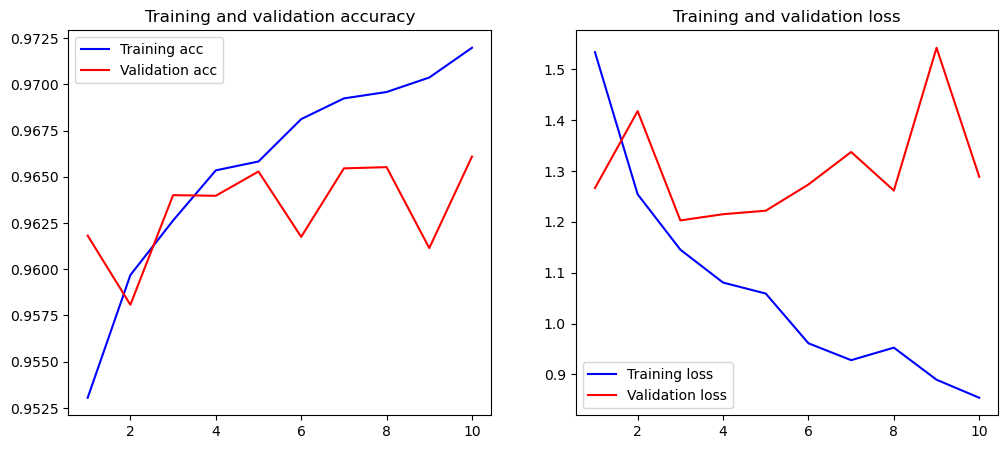

In [70]:
start_t = time.time()

train_model(my_nn1st_cat , X_train , y_train1 , y_test1, n_epochs = 10)

end_t = time.time()

print("Toatl training and redicting time is :" , end_t - start_t )

In [71]:
print("Our finalized Weights and Biases:")
print()
get_weights(my_nn1st_cat)
print()

Our finalized Weights and Biases:

Our Layers are :
embs <keras.src.engine.input_layer.InputLayer object at 0x000002746CDC0F10>

dense_21 <keras.src.layers.core.dense.Dense object at 0x0000027472516410>

dense_22 <keras.src.layers.core.dense.Dense object at 0x000002746C034250>

dropout_7 <keras.src.layers.regularization.dropout.Dropout object at 0x000002746F4D6E10>

dense_23 <keras.src.layers.core.dense.Dense object at 0x000002746C05CC10>

For Our Dense Layer:
Weights
[<tf.Variable 'dense_21/kernel:0' shape=(600, 200) dtype=float32, numpy=
array([[ 0.20038381, -0.05097927,  0.02611516, ..., -0.05419478,
        -0.0226548 , -0.094544  ],
       [-0.01463318,  0.00634139, -0.04270278, ..., -0.09708425,
        -0.15511242, -0.2052714 ],
       [-0.02928525, -0.067219  , -0.01976705, ...,  0.046033  ,
        -0.00424307, -0.00691085],
       ...,
       [-0.09689397,  0.09262917, -0.00067139, ...,  0.10742086,
        -0.11931397, -0.0788094 ],
       [ 0.08588628, -0.13589174, -0.15418

## Category Level 2

In [72]:
y2 = labeler(io["category_level_2"][:10915])


X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size=0.2,random_state=42)

y_train2 = to_categorical(y_train)

['accident and emergency incident' 'accomplishment' 'act of terror'
 'animal' 'anniversary' 'armed conflict' 'arts and entertainment'
 'biomedical science' 'bodybuilding' 'business information' 'ceremony'
 'civil unrest' 'climate change' 'communities' 'competition discipline'
 'conservation' "coup d'etat" 'crime' 'culture' 'demographics' 'disaster'
 'disciplinary action in sport' 'discrimination' 'diseases and conditions'
 'drug use in sport' 'economic sector' 'economy' 'election'
 'emergency incident' 'emergency planning' 'emergency response'
 'emigration' 'employment' 'employment legislation'
 'environmental politics' 'environmental pollution' 'exercise and fitness'
 'family' 'fundamental rights' 'government' 'government policy'
 'health facility' 'health organisations' 'health treatment'
 'healthcare policy' 'immigration' 'international relations'
 'interreligious dialogue' 'judiciary' 'justice' 'labour market'
 'labour relations' 'law' 'law enforcement' 'leisure' 'lifestyle'
 'mank

In [73]:
y_test2 = to_categorical(y_test) # Transoforming our labels to one-hot form ,in order to put them on our NN

In [74]:
my_nn2nd_cat = FcNN(109)

In [75]:
my_nn2nd_cat.summary()

Model: "News_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embs (InputLayer)           [(None, 600)]             0         
                                                                 
 dense_24 (Dense)            (None, 200)               120200    
                                                                 
 dense_25 (Dense)            (None, 360)               72360     
                                                                 
 dropout_8 (Dropout)         (None, 360)               0         
                                                                 
 dense_26 (Dense)            (None, 109)               39349     
                                                                 
Total params: 231909 (905.89 KB)
Trainable params: 231909 (905.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/10
437/437 [==============================] - 3s 4ms/step - loss: 3.2617 - accuracy: 0.9907 - precision: 0.4567 - recall: 0.0853 - val_loss: 2.8461 - val_accuracy: 0.9908 - val_precision: 0.4972 - val_recall: 0.1511
Epoch 2/10
437/437 [==============================] - 2s 4ms/step - loss: 2.5221 - accuracy: 0.9911 - precision: 0.5415 - recall: 0.2072 - val_loss: 2.7243 - val_accuracy: 0.9908 - val_precision: 0.4988 - val_recall: 0.2456
Epoch 3/10
437/437 [==============================] - 2s 4ms/step - loss: 2.3487 - accuracy: 0.9915 - precision: 0.5738 - recall: 0.2762 - val_loss: 2.6455 - val_accuracy: 0.9913 - val_precision: 0.5581 - val_recall: 0.2530
Epoch 4/10
437/437 [==============================] - 2s 3ms/step - loss: 2.2152 - accuracy: 0.9919 - precision: 0.6052 - recall: 0.3220 - val_loss: 2.7692 - val_accuracy: 0.9912 - val_precision: 0.5363 - val_recall: 0.2748
Epoch 5/10
437/437 [==============================] - 2s 4ms/step - loss: 2.1250 - accuracy: 0.9921 - pr

C:\Users\Desktop\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Desktop\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Desktop\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Desktop\anaconda3\Lib\site-packages\skle

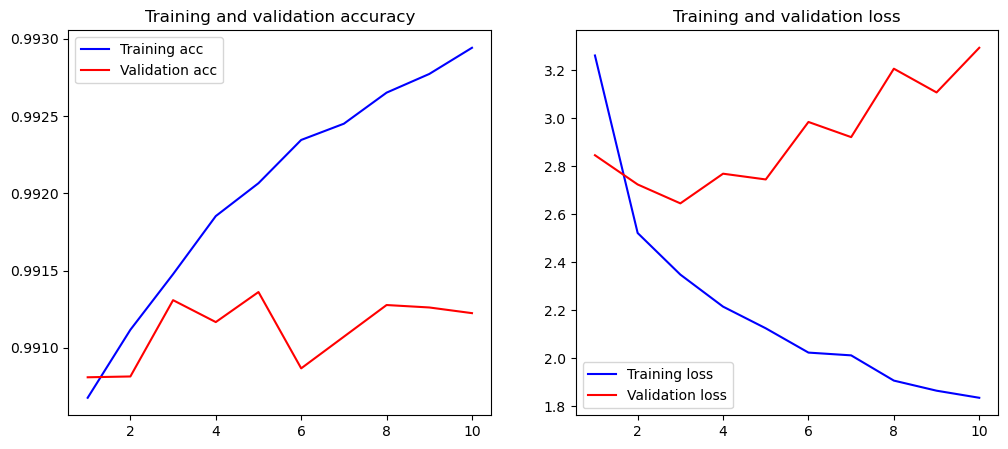

In [76]:
st_t = time.time()

train_model(my_nn2nd_cat , X_train , y_train2 , y_test2, n_epochs = 10)

en_t = time.time()

print("Toatl training and redicting time is :" , en_t - st_t )

In [77]:
print("Our finalized Weights and Biases:")
print()
get_weights(my_nn2nd_cat)
print()

Our finalized Weights and Biases:

Our Layers are :
embs <keras.src.engine.input_layer.InputLayer object at 0x000002746CE98F10>

dense_24 <keras.src.layers.core.dense.Dense object at 0x000002745BD38F10>

dense_25 <keras.src.layers.core.dense.Dense object at 0x000002746CECF750>

dropout_8 <keras.src.layers.regularization.dropout.Dropout object at 0x000002747795D750>

dense_26 <keras.src.layers.core.dense.Dense object at 0x000002746CA99250>

For Our Dense Layer:
Weights
[<tf.Variable 'dense_24/kernel:0' shape=(600, 200) dtype=float32, numpy=
array([[ 0.13424198,  0.14221424, -0.05858219, ...,  0.16185795,
        -0.07276693, -0.05420043],
       [ 0.17575982, -0.04638582, -0.03583738, ..., -0.1602351 ,
        -0.0615074 ,  0.0502923 ],
       [ 0.15561567,  0.12675315,  0.11813391, ..., -0.02749965,
         0.07465747, -0.00239251],
       ...,
       [ 0.10635848, -0.0175225 ,  0.07700382, ...,  0.1284755 ,
        -0.00327858, -0.02691853],
       [-0.10009849, -0.1790869 ,  0.05168